# Extracting historical data. BOCD.


I want to backtest buying call spreads on SPY (buying the strike price that is
at-the-money and selling the higher strike) in order to get bullish exposure to the underlying. Spreads define the
potential risk and reduce the cost of trade. Exits will be dictated by abrupt changes in SPY price identified by bayesian online change point detection algorithm.


### Extracting historical data

In [2]:
from ibapi.client import EClient
from ibapi.wrapper import EWrapper
from ibapi.contract import Contract
import pandas as pd
import time
from threading import Thread, Event
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import arviz as az

We extract 6 months of historical data and implied volatility data for SPY. Interactive Brokers doesn't provide historical options data, so when backtesting we'll use workaround and derive options prices from implied volatility using Black-Sholes model. 


In [3]:
class Client(EWrapper, EClient):
    
    def __init__(self, addr, port, client_id):
        EClient.__init__(self, self)
        self.data = pd.DataFrame(np.nan, index = range(1), columns = ['date', 'o', 'h', 'l', 'c', 'v'])
        self.imp_data = pd.DataFrame(np.nan, index = range(1), columns = ['date', 'o', 'h', 'l', 'c'])
        self.event = Event()
        
        self.connect(addr, port, client_id)

        thread = Thread(target=self.run, daemon = True)
        thread.start()
    
    def historicalData(self, reqId, bar):        
        if reqId == 1:
            hist_bar = { 'date' : bar.date, 'o' : bar.open, 'h' : bar.high, 'l' : bar.low, 'c' : bar.close,
               'v' : bar.volume }
            self.data = pd.concat([self.data, pd.DataFrame.from_records([hist_bar])], ignore_index = True) 
            
        elif reqId == 2:
            imp_bar = { 'date' : bar.date, 'o' : bar.open, 'h' : bar.high, 'l' : bar.low, 'c' : bar.close }
            self.imp_data = pd.concat([self.imp_data, pd.DataFrame.from_records([imp_bar])], ignore_index = True) 
        
    def historicalDataEnd(self,reqId,  start,  end):
        print(f'Finished extracting data for reqId {reqId}', start, end)         
        self.event.set()

In [4]:
client = Client('127.0.0.1', 4002, 0) #7497 for tws

ERROR -1 2104 Market data farm connection is OK:hfarm
ERROR -1 2106 HMDS data farm connection is OK:hkhmds
ERROR -1 2158 Sec-def data farm connection is OK:secdefhk


In [5]:
contract = Contract()
contract.symbol = 'SPY'
contract.secType = 'STK'
contract.exchange = 'SMART'
contract.currency = 'USD'

In [6]:

client.reqHistoricalData(1, contract, '', durationStr='6 M', barSizeSetting='2 mins', whatToShow='ADJUSTED_LAST', useRTH=1, formatDate=1, keepUpToDate=0, chartOptions=[]) 

while not client.event.is_set():
    client.event.wait()
    
client.event.clear()

ERROR -1 2106 HMDS data farm connection is OK:ushmds


Finished extracting data for reqId 1 20230406 15:39:04 US/Eastern 20231006 15:39:04 US/Eastern


In [7]:
client.data = client.data.iloc[1:, :]

In [8]:
client.data

,date,o,h,l,c,v
1,20230410 09:30:00 US/Eastern,403.6709,403.9092,403.3036,403.3135,904969
2,20230410 09:32:00 US/Eastern,403.3036,403.4326,403.1547,403.4029,463724
3,20230410 09:34:00 US/Eastern,403.3929,403.4724,403.0653,403.1745,526619
4,20230410 09:36:00 US/Eastern,403.1745,403.3334,403.0455,403.2341,503600
5,20230410 09:38:00 US/Eastern,403.2142,403.4724,403.0752,403.4624,491287
...,...,...,...,...,...,...
24466,20231006 15:30:00 US/Eastern,430.7700,430.9500,430.6400,430.6700,494044
24467,20231006 15:32:00 US/Eastern,430.6800,430.7400,430.3800,430.5000,362984
24468,20231006 15:34:00 US/Eastern,430.5000,430.5300,430.3500,430.4800,236562
24469,20231006 15:36:00 US/Eastern,430.5000,430.7300,430.4400,430.6900,287113


In [9]:
client.reqHistoricalData(2, contract, '', durationStr='6 M', barSizeSetting='2 mins', whatToShow='OPTION_IMPLIED_VOLATILITY', useRTH=1, formatDate=1, keepUpToDate=0, chartOptions=[])  

while not client.event.is_set():
    client.event.wait()
    
client.event.clear()

Finished extracting data for reqId 2 20230406 15:40:12 US/Eastern 20231006 15:40:12 US/Eastern


In [10]:
client.imp_data = client.imp_data.iloc[1:, :]
client.imp_data

,date,o,h,l,c
1,20230410 09:30:00 US/Eastern,0.165095,0.177794,0.165095,0.177794
2,20230410 09:32:00 US/Eastern,0.177794,0.177794,0.177794,0.177794
3,20230410 09:34:00 US/Eastern,0.177794,0.177794,0.177794,0.177794
4,20230410 09:36:00 US/Eastern,0.177794,0.177794,0.177794,0.177794
5,20230410 09:38:00 US/Eastern,0.177794,0.177794,0.177794,0.177794
...,...,...,...,...,...
24467,20231006 15:32:00 US/Eastern,0.150808,0.150808,0.150808,0.150808
24468,20231006 15:34:00 US/Eastern,0.150808,0.150808,0.150808,0.150808
24469,20231006 15:36:00 US/Eastern,0.150808,0.150808,0.150808,0.150808
24470,20231006 15:38:00 US/Eastern,0.150808,0.150808,0.150808,0.150808


In [11]:
client.imp_data = client.imp_data.iloc[:-1, :]

In [12]:
client.disconnect()

In [14]:
#save for later use 
client.data.to_csv('spy_2min_data.csv')
client.imp_data.to_csv('spy_imp_vol_2min_data.csv')

In [3]:
data_file_path ="./spy_2min_data.csv"  
    
prices = pd.read_csv(data_file_path)

In [4]:
prices.head()

,Unnamed: 0,date,o,h,l,c,v
0,1,20230410 09:30:00 US/Eastern,403.6709,403.9092,403.3036,403.3135,904969
1,2,20230410 09:32:00 US/Eastern,403.3036,403.4326,403.1547,403.4029,463724
2,3,20230410 09:34:00 US/Eastern,403.3929,403.4724,403.0653,403.1745,526619
3,4,20230410 09:36:00 US/Eastern,403.1745,403.3334,403.0455,403.2341,503600
4,5,20230410 09:38:00 US/Eastern,403.2142,403.4724,403.0752,403.4624,491287


In [5]:
prices = prices.drop(['Unnamed: 0'], axis = 1)

In [6]:
from utils.spy_client import process_date

prices.loc[:, 'date'] =  prices.loc[:, 'date'] .apply(process_date)

In [7]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24470 entries, 0 to 24469
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    24470 non-null  object 
 1   o       24470 non-null  float64
 2   h       24470 non-null  float64
 3   l       24470 non-null  float64
 4   c       24470 non-null  float64
 5   v       24470 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.1+ MB


In [8]:
prices.to_csv('SPY_data.csv')

In [9]:
import pyqstrat as pq

<Figure size 640x480 with 0 Axes>

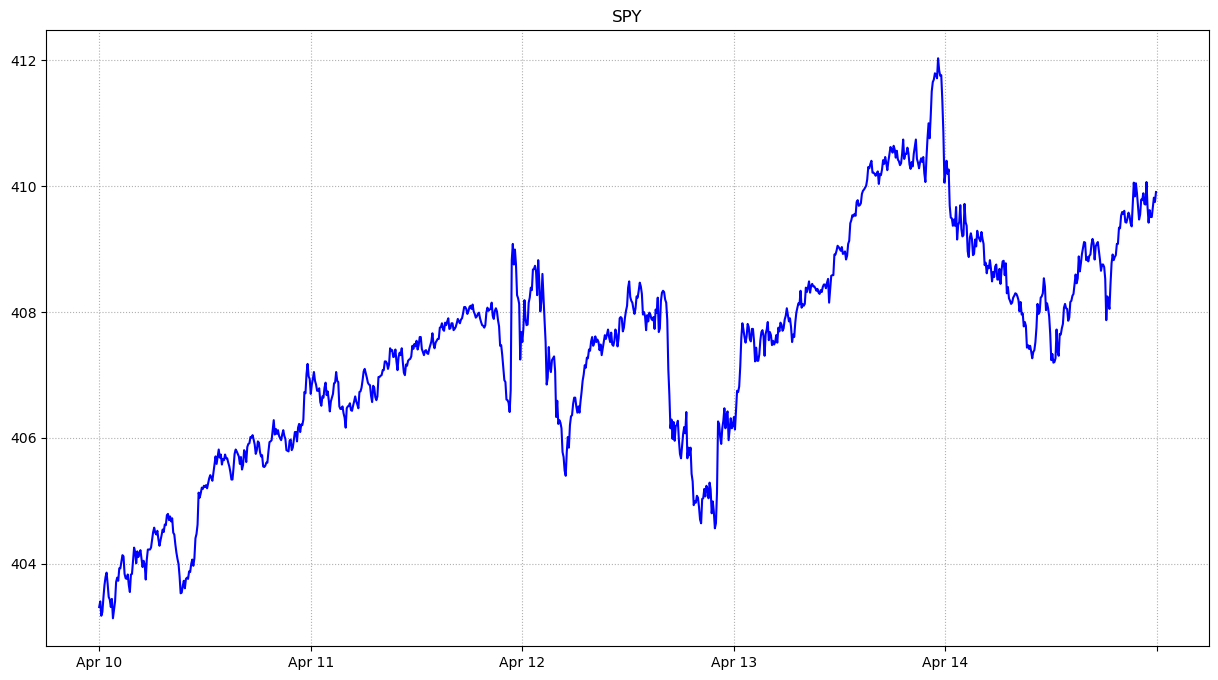

In [10]:
prices_subplot = pq.Subplot(
    [pq.TimeSeries('price', prices.date.values[:1000], prices.c[:1000], display_attributes=pq.LinePlotAttributes(color = 'blue'))]
   )
plot = pq.Plot(prices_subplot, title = 'SPY', show_date_gaps = False)
plot.draw();

In [11]:
imp_vol = pd.read_csv('./spy_imp_vol_2min_data.csv')

In [12]:
imp_vol

,Unnamed: 0,date,o,h,l,c
0,1,20230410 09:30:00 US/Eastern,0.165095,0.177794,0.165095,0.177794
1,2,20230410 09:32:00 US/Eastern,0.177794,0.177794,0.177794,0.177794
2,3,20230410 09:34:00 US/Eastern,0.177794,0.177794,0.177794,0.177794
3,4,20230410 09:36:00 US/Eastern,0.177794,0.177794,0.177794,0.177794
4,5,20230410 09:38:00 US/Eastern,0.177794,0.177794,0.177794,0.177794
...,...,...,...,...,...,...
24465,24466,20231006 15:30:00 US/Eastern,0.150808,0.150808,0.150808,0.150808
24466,24467,20231006 15:32:00 US/Eastern,0.150808,0.150808,0.150808,0.150808
24467,24468,20231006 15:34:00 US/Eastern,0.150808,0.150808,0.150808,0.150808
24468,24469,20231006 15:36:00 US/Eastern,0.150808,0.150808,0.150808,0.150808


In [13]:
imp_vol = imp_vol.drop(['Unnamed: 0'], axis = 1)

In [14]:
imp_vol.to_csv('SPY_implied_vol.csv')

## Bayesian online changepoint detection

   Changepoints are abrupt changes in the mean or variance of a time series and Bayesian Online Changepoint Detection (BOCD) is a discrete-time inference framework introduced by [Adams & MacKay (2007)](https://arxiv.org/abs/0710.3742).   
    
   
   The algorithm computes a probability distribution over the possible run lengths at each point in the data, where run length refers to the number of observations since the last changepoint. When the probability of a 0-length run spikes, there is most likely a change point at the current data point.
   
   A great explanation of the algorithm can be found [here](https://web.archive.org/web/20220809093056/https://scientya.com/bayesian-online-change-point-detection-an-intuitive-understanding-b2d2b9dc165b?gi=3cbe44d22f7e).  

An important part of the BOCD is evaluating the predictive distribution (conditional on each
possible run length) at the new datum. For an arbitrary prior-likelihood combination these calculations may be intractable, requiring MCMC or other numerical techniques. However, we can leverage **conjugacy**, allowing us to incrementally update hyperparametes.


## NormalGamma prior

Suppose the data is assumed to be from normal population, but we don't know the mean and variance of distribution. As variance is unknown, we use a prior distribution to describe the uncertainty about the variance before seeing data.
			Since the variance is non-negative, continuous, and with no upper limit, a gamma distribution is a good candidate prior for the variance.
			 The inverse of the variance, which is known as the precision, has a conjugate gamma prior distribution.

<!-- \begin{align}
n \mid N, \theta \sim \text{Binom}(N, \theta).
\end{align}

Writing out the PMF, this is

\begin{align}
f(n\mid N, \theta) = \begin{pmatrix}N\\n\end{pmatrix} \theta^n(1-\theta)^{N-n}.
\end{align} -->
Let 
\begin{align}
X_{1}, . . . , X_{n} \sim \text{Norm}(\mu, \lambda^{-1})
\end{align}
<!-- ∼ Norm(\mu , λ^{-1} -->
<!-- ) and assume both -->

and assume that both mean and precision are unknown.

<!-- This identifies a single parameter to estimate, $\theta$, which is the probability of hatching. Our goal, then, is to compute $g(\theta\mid n,N)$. -->

The $\text {NormalGamma}(m, c, a, b)$ distribution, with *m* ∈ R and
*c*, *a*, *b* > 0, is a joint distribution on ($\mu, \lambda)$ obtained by letting

\begin{align}
\mu \mid\lambda \sim \text{Norm}(m, (c\lambda)^{-1}).
\end{align}

\begin{align}
\lambda \sim \text{Gamma}(a, b).
\end{align}

the joint pdf is

\begin{align}
p(\mu \mid\lambda) = p(\mu \mid\lambda)  p(\lambda) = \text{Norm} (\mu \mid m,(cλ)^{-1}
) \text{Gamma}(\lambda \mid a, b)
.
\end{align}

which is denoted as 
\begin{align}
\text{NormalGamma}(µ, λ | m, c, a, b).
 \end{align}

Given this model, the posterior is 

\begin{align}
\mu,\lambda \mid x_{1:n} \sim \text{NormalGamma}( M, C, A, B)
\end{align}

After observation of new data, the parameters are updated according to these formulas (see https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf for derivations):

\begin{gather*}
M =  \frac{cm + \sum_{i=1}^n x_{i}} {c + n} \\
C = c + n\\
A = A + n/2 \\
B = b + \frac{1} {2} \sum_{i=1}^n (x_i - \overline{x})^2 + \frac{1} {2} \frac {cn}{c + n } (\overline{x} - m)^2 
\end{gather*}
 

 

 M is posterior mean for µ, C is “sample size” for estimating µ, and A and B are shape and rate for posterior on λ. See http://www2.stat.duke.edu/~rcs46/modern_bayes17/lecturesModernBayes17/lecture-4/04-normal-gamma.pdf for more explanation.

 Due to conjugacy we can easily update parameters, as the prior and posterior have the same form, so the update of the prior by the data via the likelihood simply updates the parameters of the distribution describing the parameter values.
<br> <br> Suppose we have some parameters for prior and we would like to obtain posterior after observing some new data:

In [15]:
%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 84735
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [16]:
# parameters for prior
m_0 = 3
c = 1 # we unsure about our estimation of mean
a_0 = 1 
b_0 = 1

In [17]:
normal = np.random.normal(loc = 3, scale = 1, size=1000)

<Axes: >

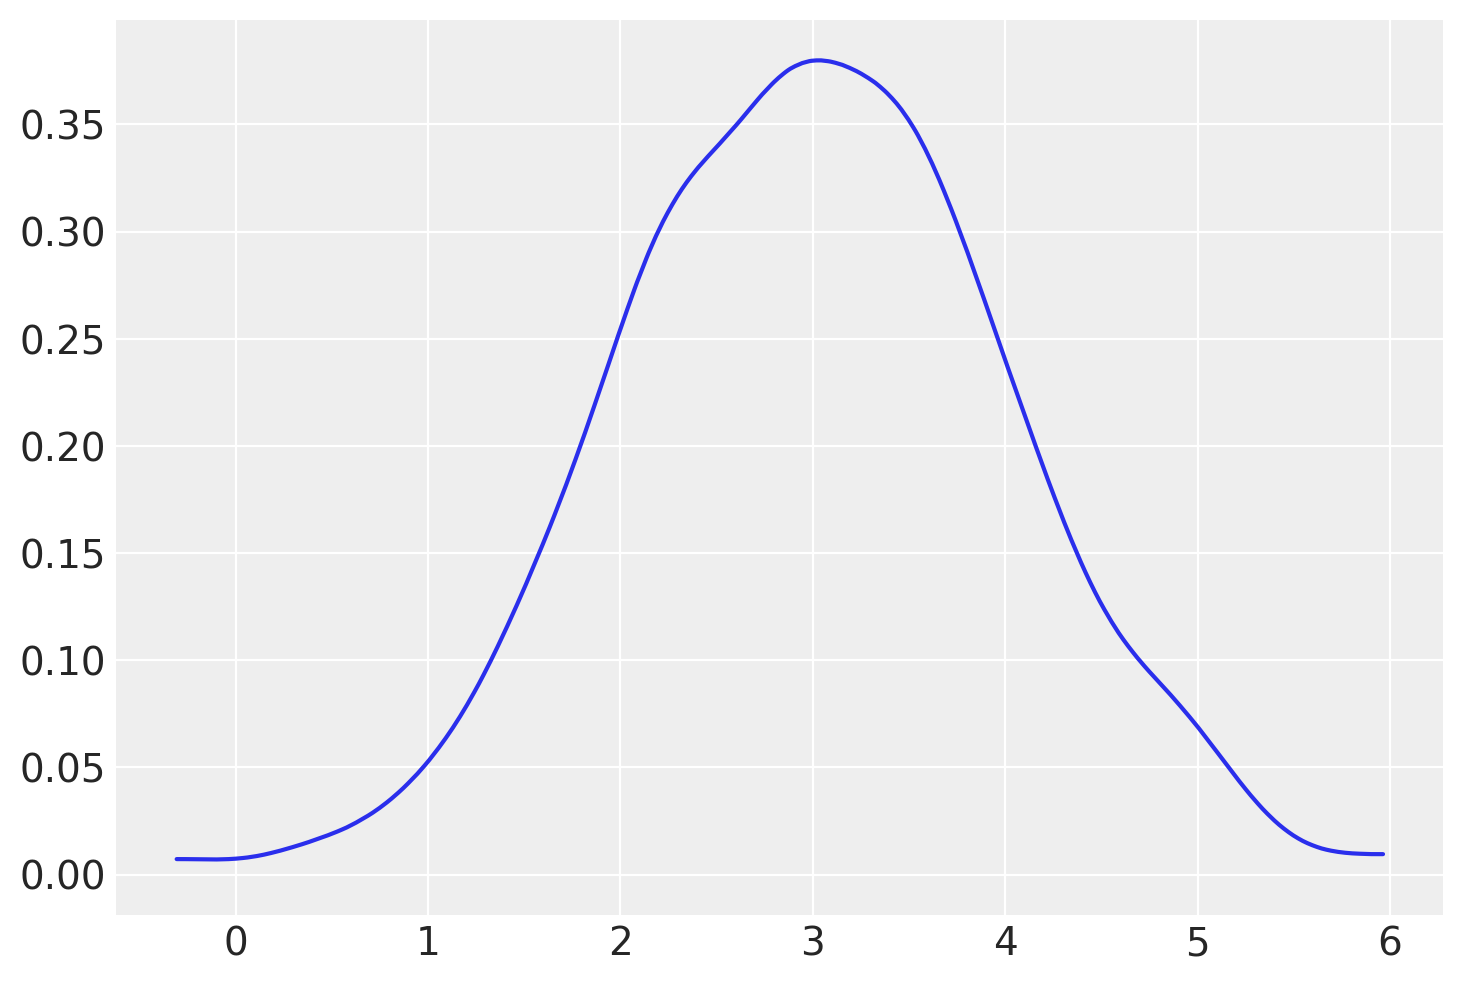

In [18]:
az.plot_dist(normal)

<Axes: >

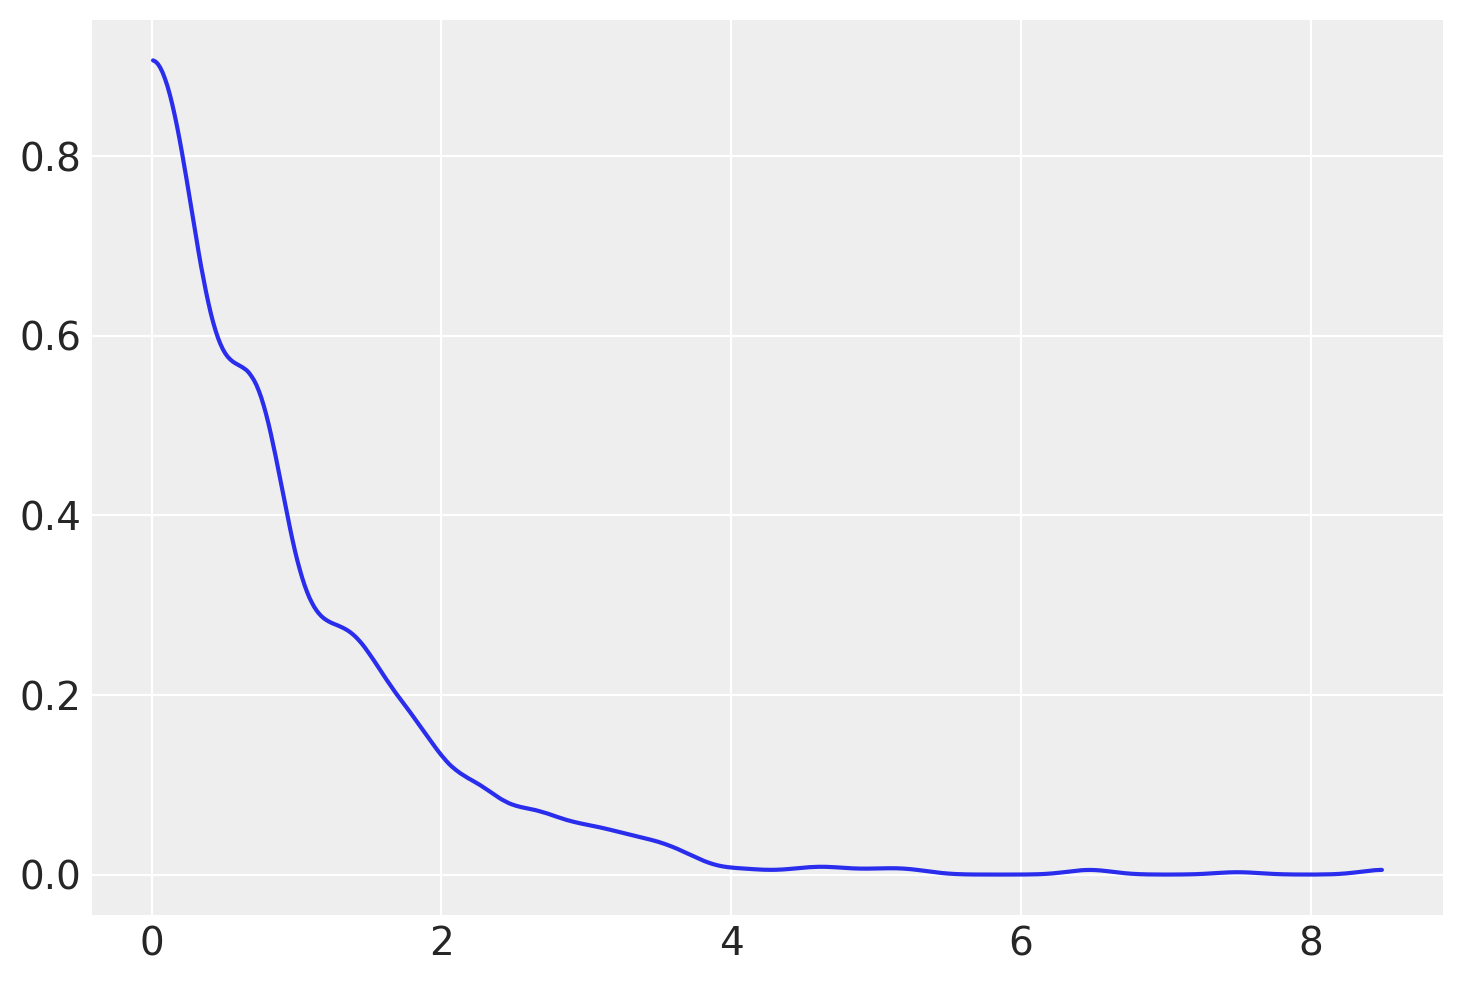

In [19]:
gamma = np.random.gamma(a_0 , 1/b_0, size=1000)
az.plot_dist(gamma)

<Axes: >

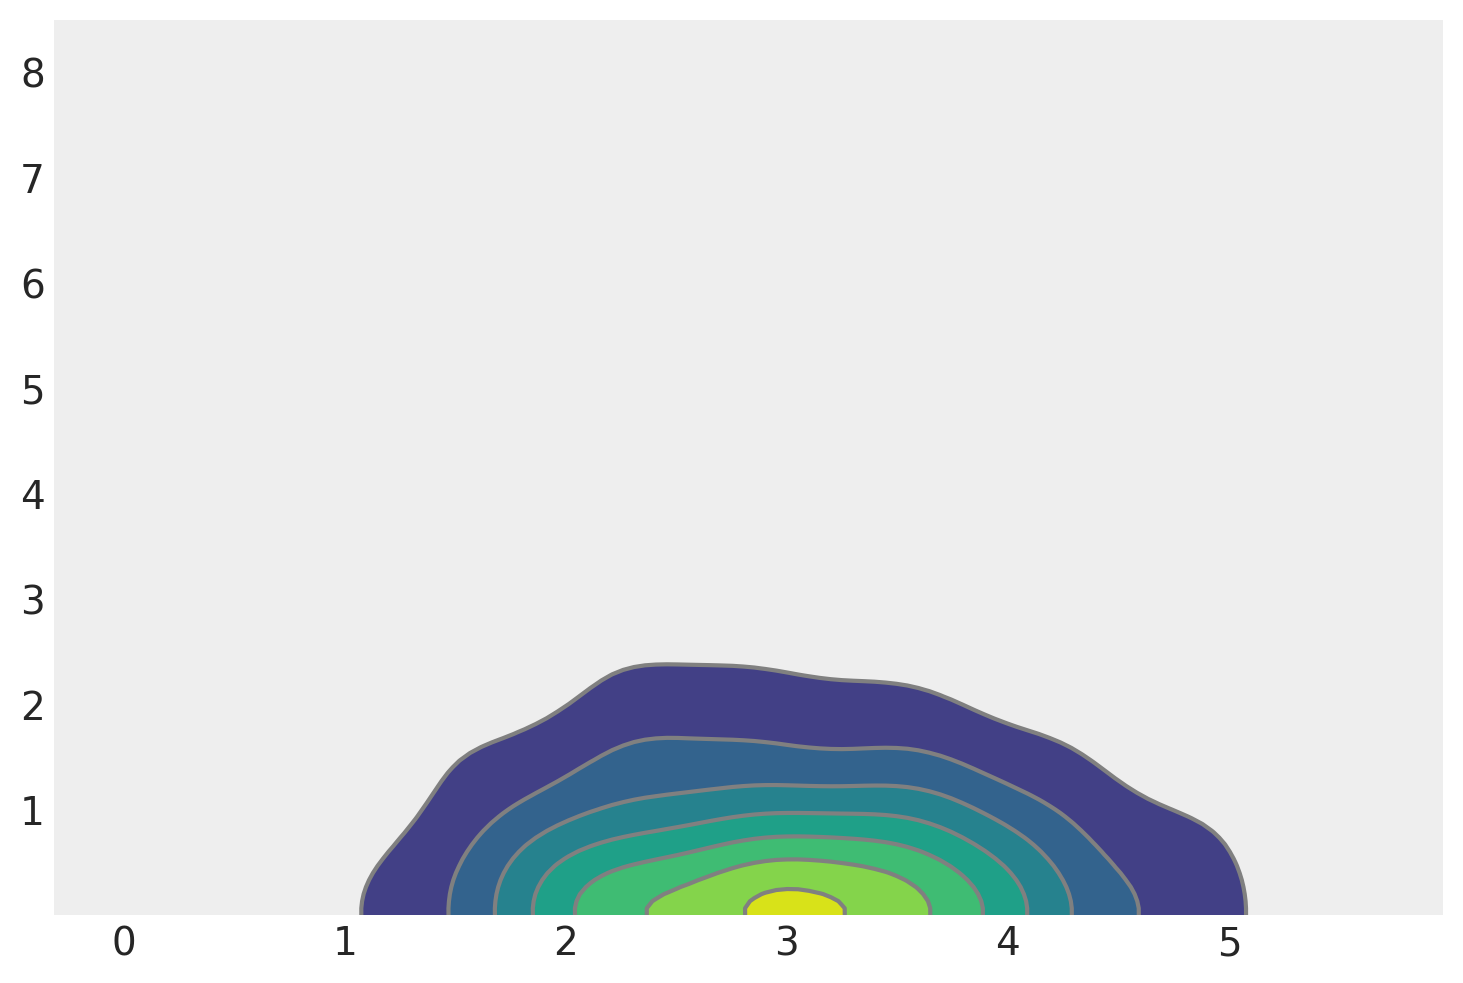

In [20]:
az.plot_kde(normal, values2=gamma)

After observing new data, we update parameters:

In [21]:
new_data = np.random.normal(loc = 4, scale = 3 , size=100)

In [22]:
x_mean = np.mean(new_data ) #sample mean
x_var = np.var(new_data) #sample variance 
n = len(new_data)

m_post = (c * m_0 + n* x_mean) / (c + n)
c_post = c + n
a_post = a_0 + 0.5 * n
b_post = b_0 + 0.5 * x_var + 0.5 * (c * n / ( c + n ))* (x_mean - m_0) ** 2

<Axes: >

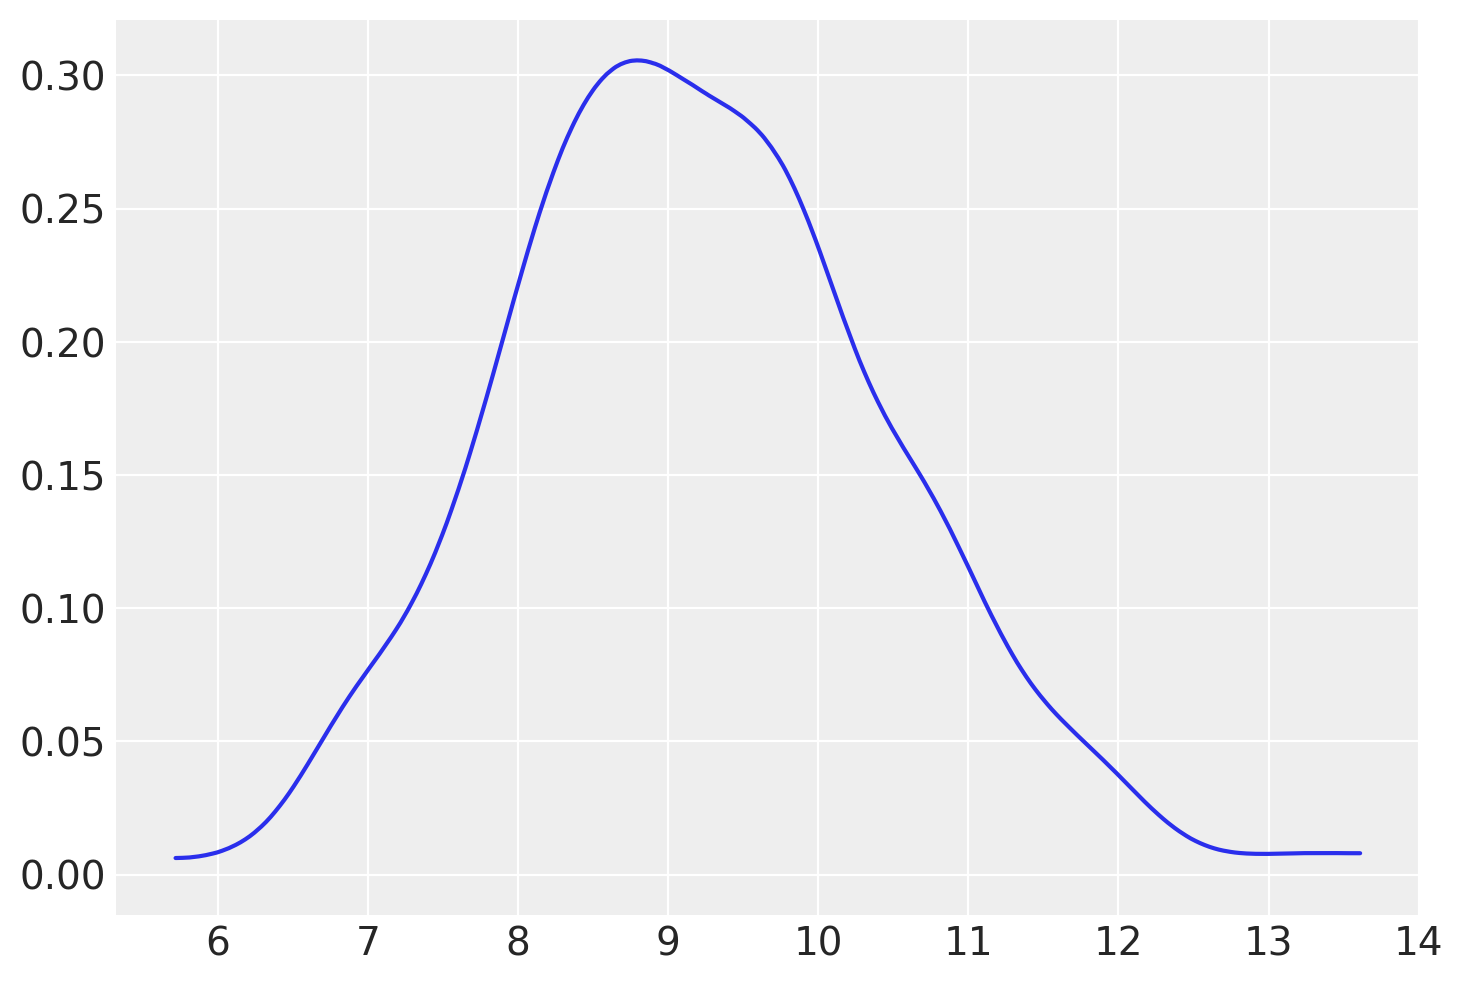

In [23]:
gamma_post = np.random.gamma(a_post, 1/b_post, size=1000)
az.plot_dist(gamma_post)

We see that mean is shifted to the right and now is around 3.8 (if we had more confidence in our prior estimation, it would be somewhere between prior and sample mean from data)

<Axes: title={'center': 'x'}>

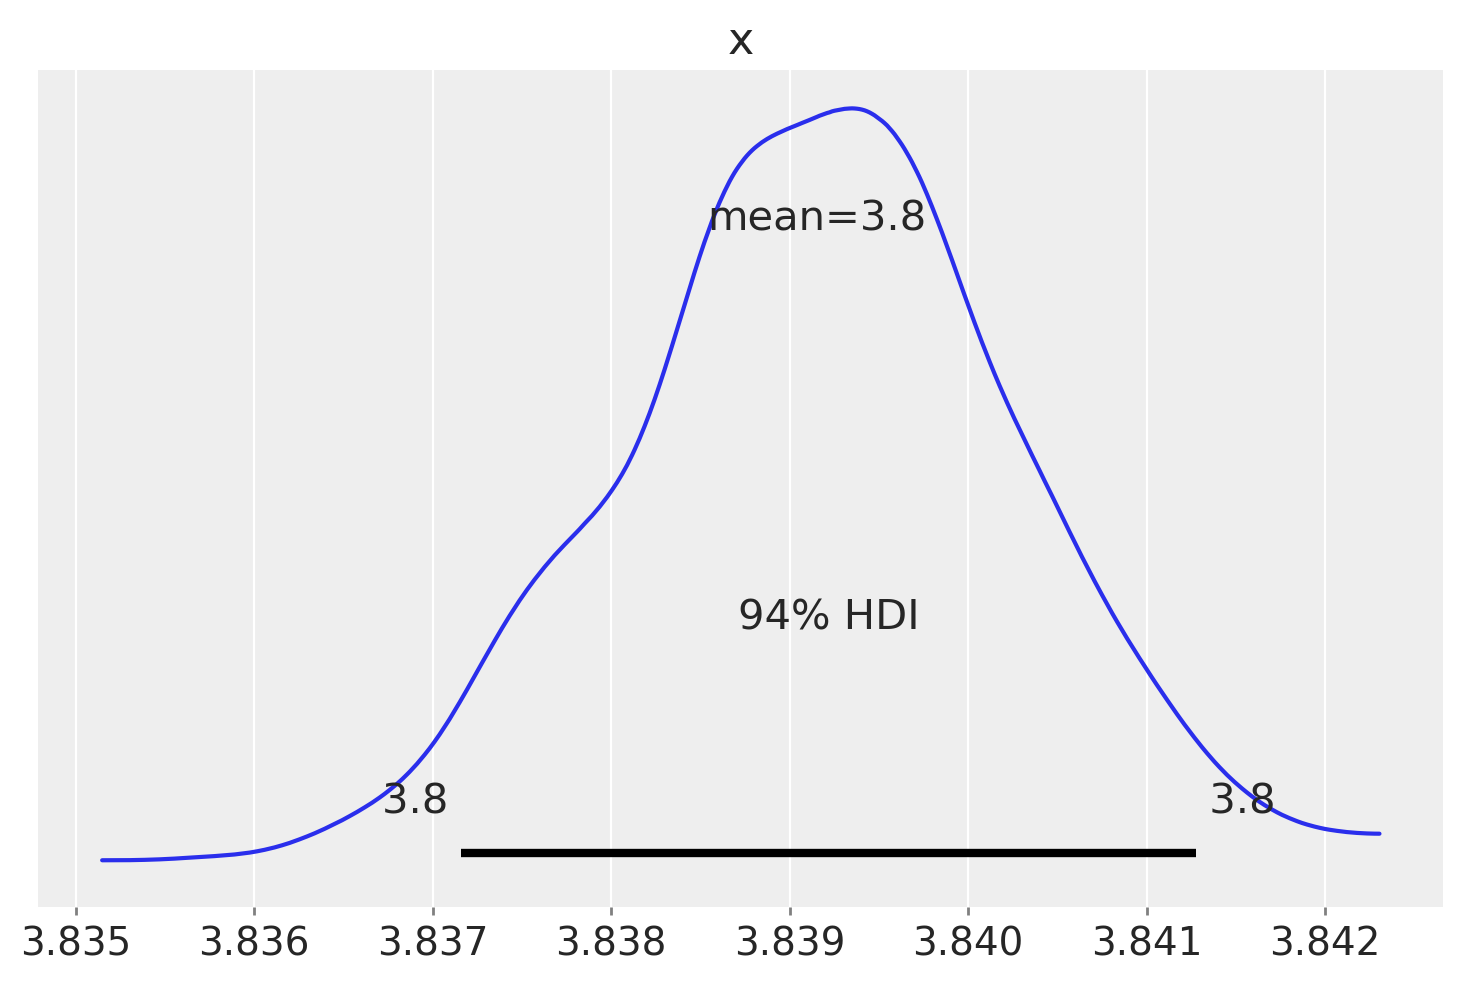

In [24]:
normal_post = np.random.normal(loc = m_post, scale = 1/(c_post *gamma_post), size=1000)
az.plot_posterior(normal_post)

<Axes: >

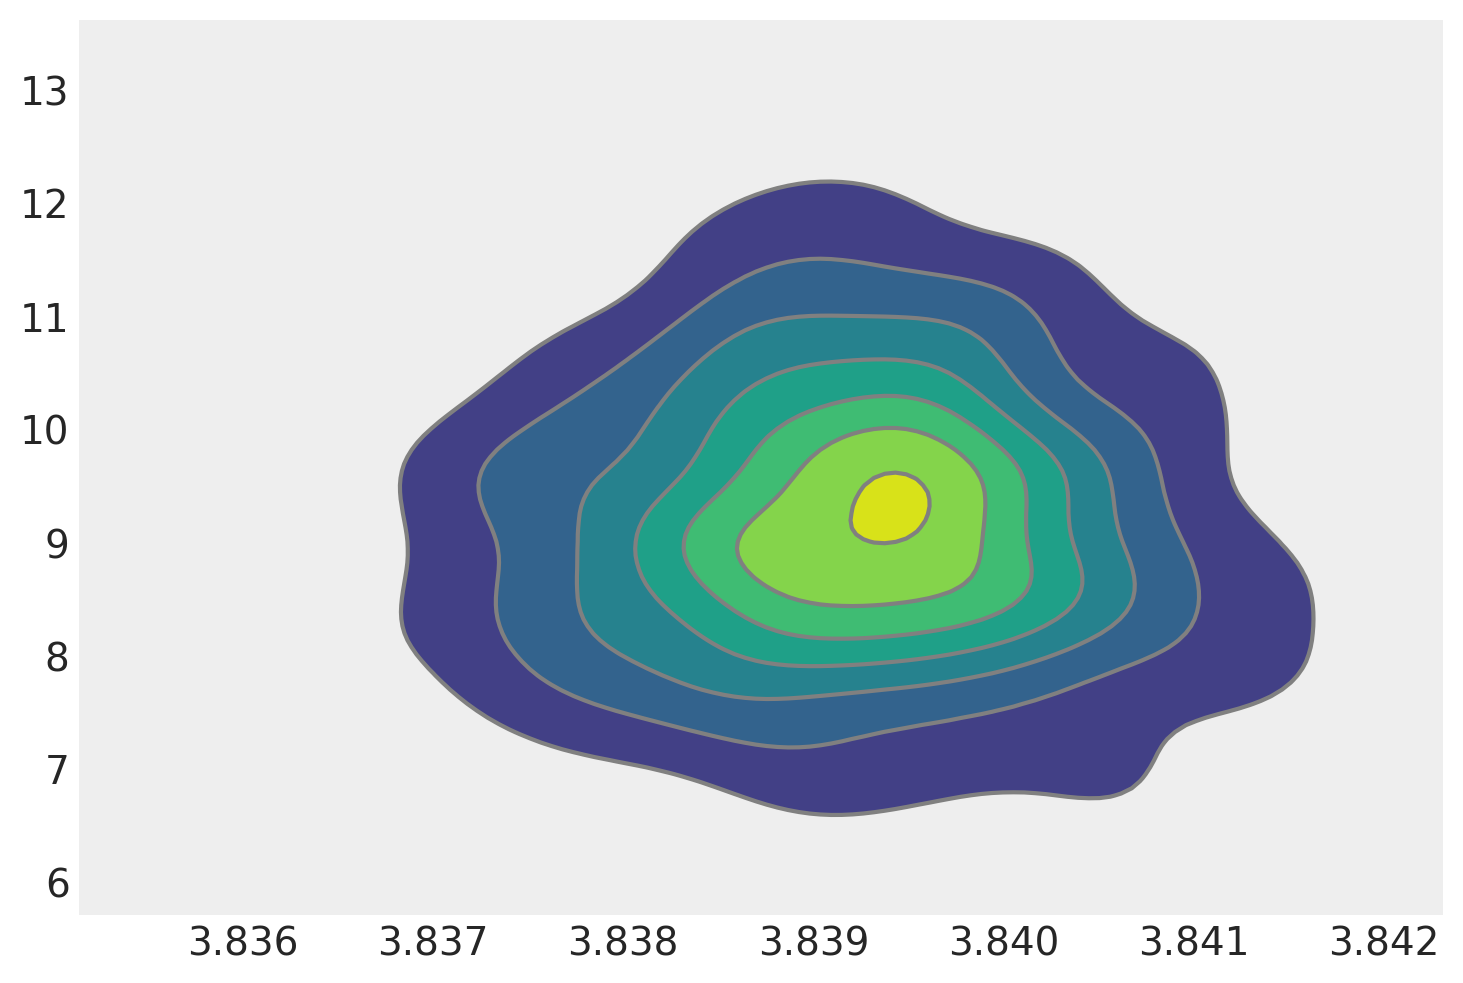

In [25]:
az.plot_kde(normal_post, values2=gamma_post)

The **posterior predictive** of an observation given a Normalgamma distribution is the probability density of the sample mean under a Student’s T-distribution with df=2$a_{post}$
, μ=$m_{post}$
, and $\Lambda=\frac {a_{post} c_{post}} {b_{post} (c_{post} + 1)}$

 


So, I assumed that our data is drawn
from a normal distribution with unknown mean and unknown variance. I chose normalgamma conjugate prior, so the hyperparameters are efficiently updated with some simple arithmetic and the
predictive distribution is a T-distribution with mean m_post and 2$\alpha$ degrees of freedom and precision
depending on the updated hyperparameters. The trend change detection is reduced to changepoint detection by taking the first difference of a time series.

In [26]:
from utils.bocd import constant_hazard, StudentT, BOCD
from functools import partial

In [28]:
prices = prices[:3000]

In [29]:
differenced = round(prices['c'].diff(1).copy(deep = False), 5)
prices['diff'] = differenced
prices['diff'] = prices['diff'].fillna(0)
prices['diff'] = prices['diff']*100

In [30]:
lambda_ = 500 #initialize 500*500 matrix for bocd algorithm
alpha = 0.1
beta = 1 
kappa = 1
mu = 0

In [31]:
bocd = BOCD(partial(constant_hazard, lambda_),
             StudentT(alpha, beta, kappa, lambda_), lambda_)

In [32]:
for x in prices['diff'].values:         
    bocd.update(x)

cp detected at index 391, value 25.82
cp detected at index 1171, value 0.0
cp detected at index 1366, value 0.9900000000000001
cp detected at index 1561, value 14.89
cp detected at index 2146, value 1.9900000000000002
cp detected at index 2536, value 1.9900000000000002


In [33]:
bocd.changepoints

[391, 1171, 1366, 1561, 2146, 2536]

C:\Users\myspa\miniforge3\lib\site-packages\IPython\core\events.py:93: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
C:\Users\myspa\miniforge3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


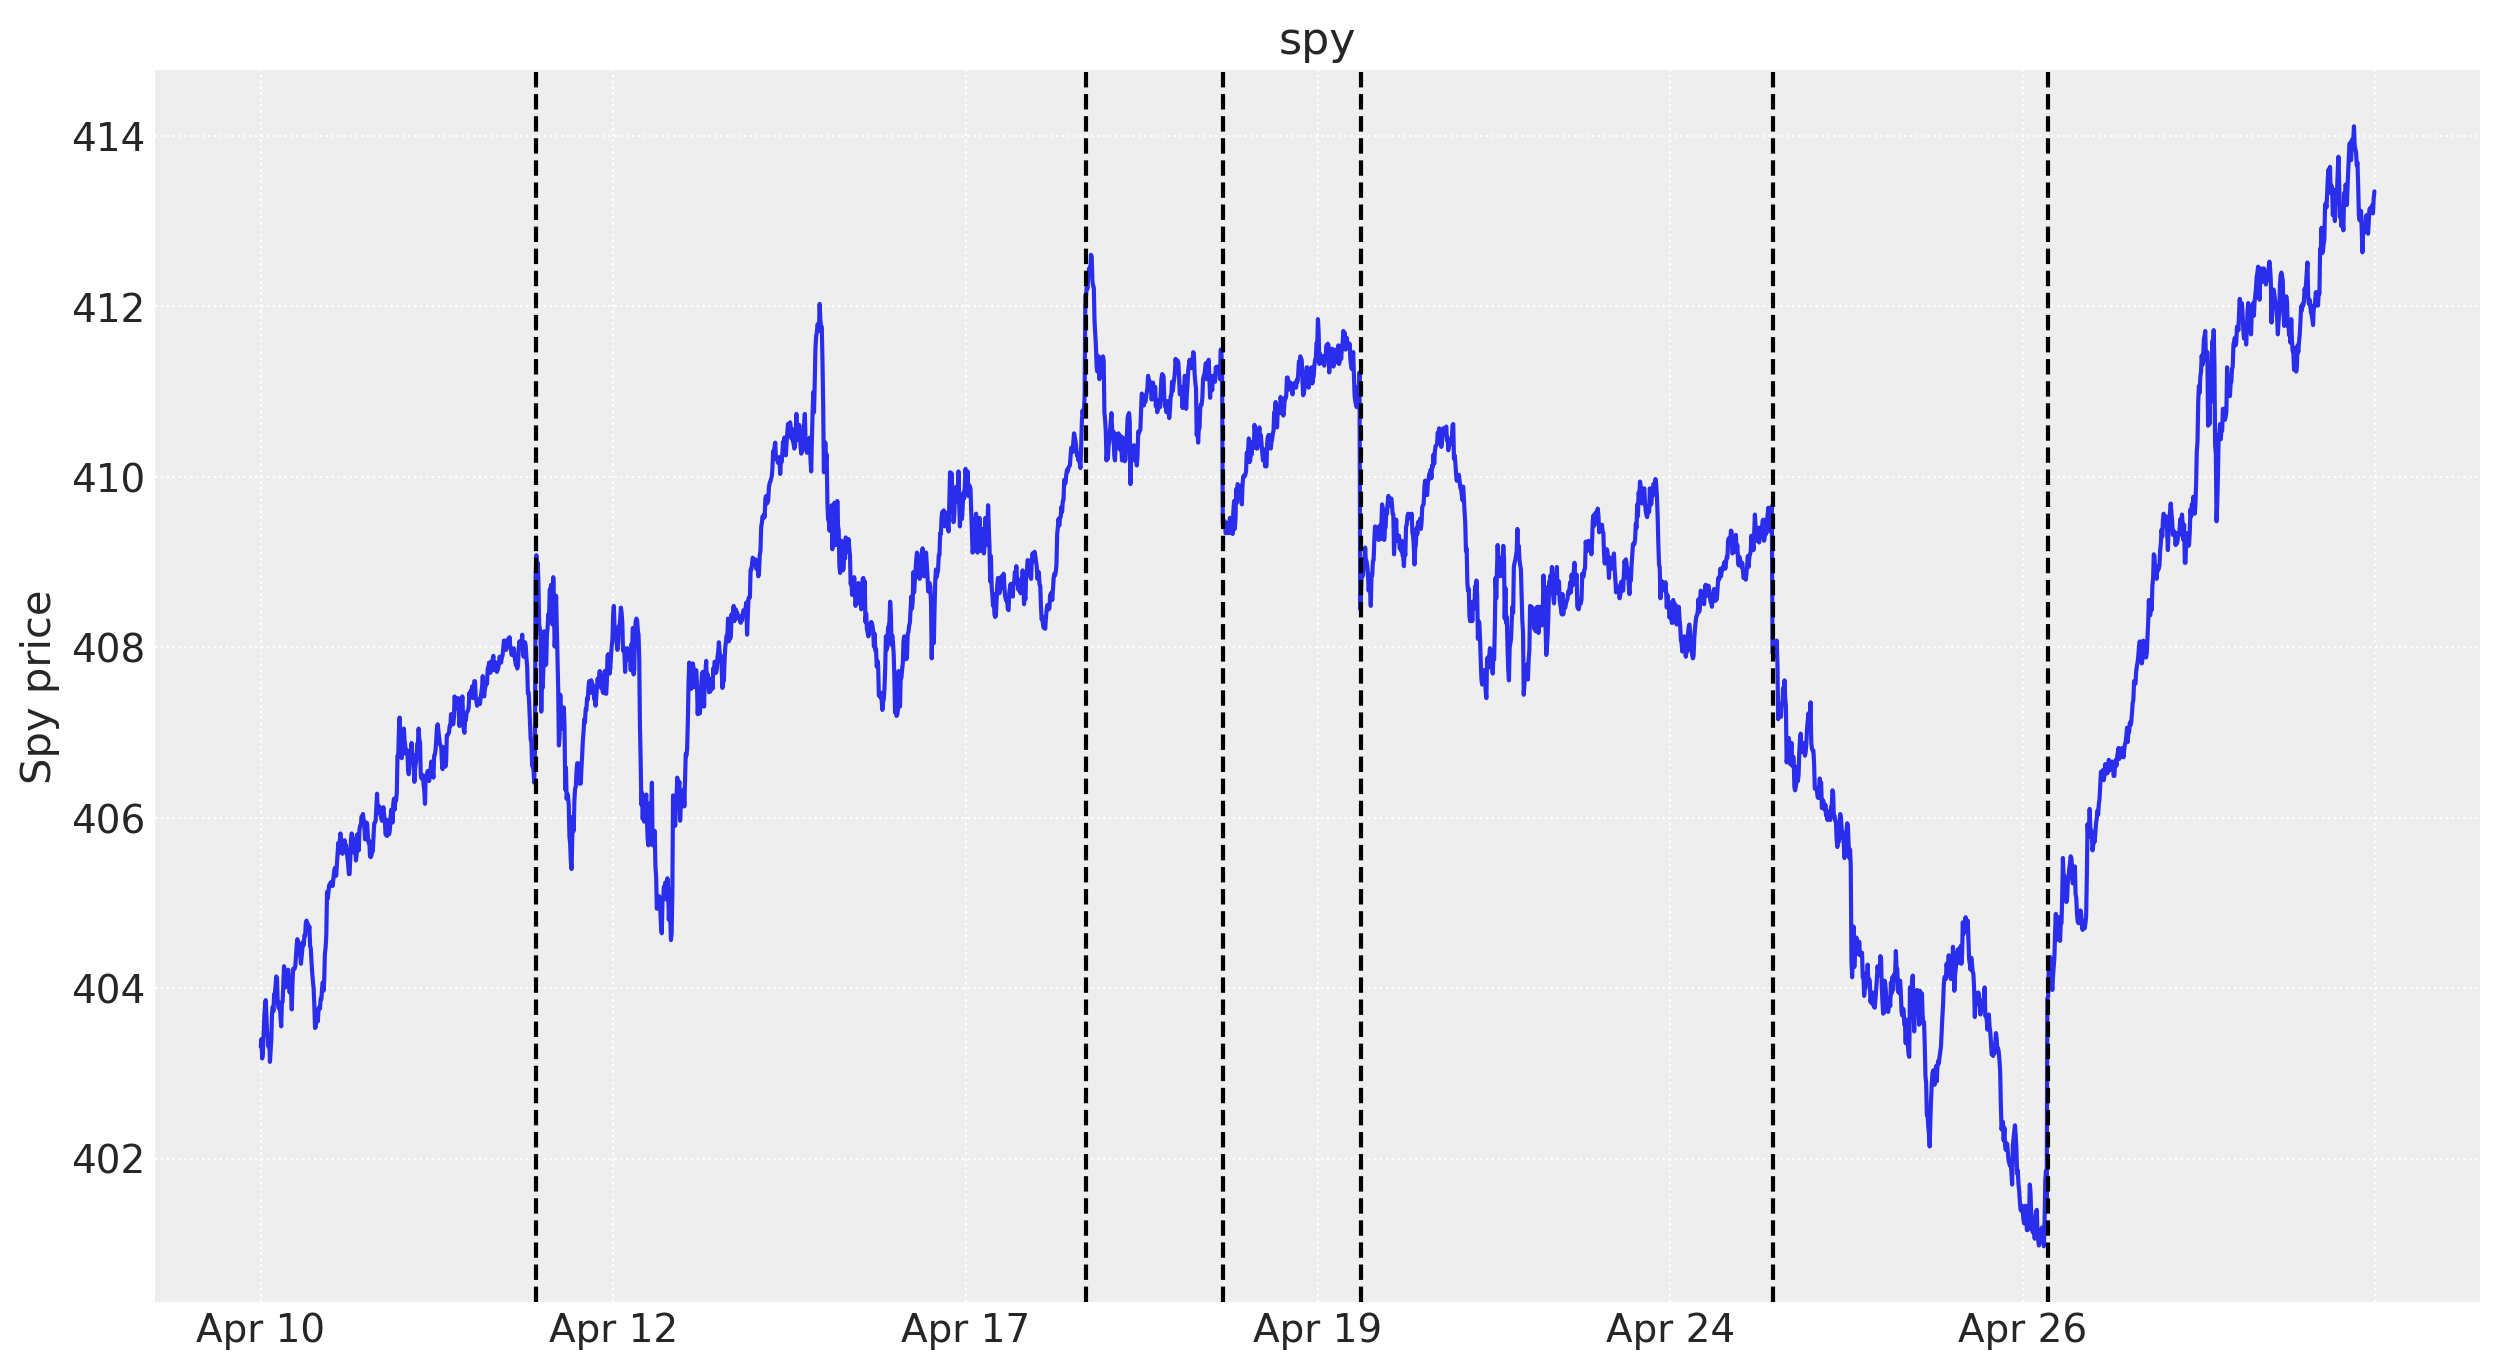

In [34]:
subplot = pq.Subplot([pq.TimeSeries('spy', prices.date, prices.c)],
                     vertical_lines = [pq.VerticalLine(x = 391, color = 'black'),
                    pq.VerticalLine(x = 1171, color = 'black'), 
                    pq.VerticalLine(x = 1366, color = 'black'),
                    pq.VerticalLine(x = 1561, color = 'black'),
                    pq.VerticalLine(x = 2146, color = 'black'),
                    pq.VerticalLine(x = 2536, color = 'black'),                                                   
                    ], ylabel = 'Spy price')

plot = pq.Plot([subplot], title = 'spy', show_date_gaps = False)

plot.draw();

C:\Users\myspa\AppData\Local\Temp\ipykernel_17872\2674468320.py:10: RuntimeWarning: divide by zero encountered in log
  -np.log(bocd.R[0:-1:sparsity, 0:-1:sparsity]),


Text(0, 0.5, 'Changepoint Probability $\\to$')

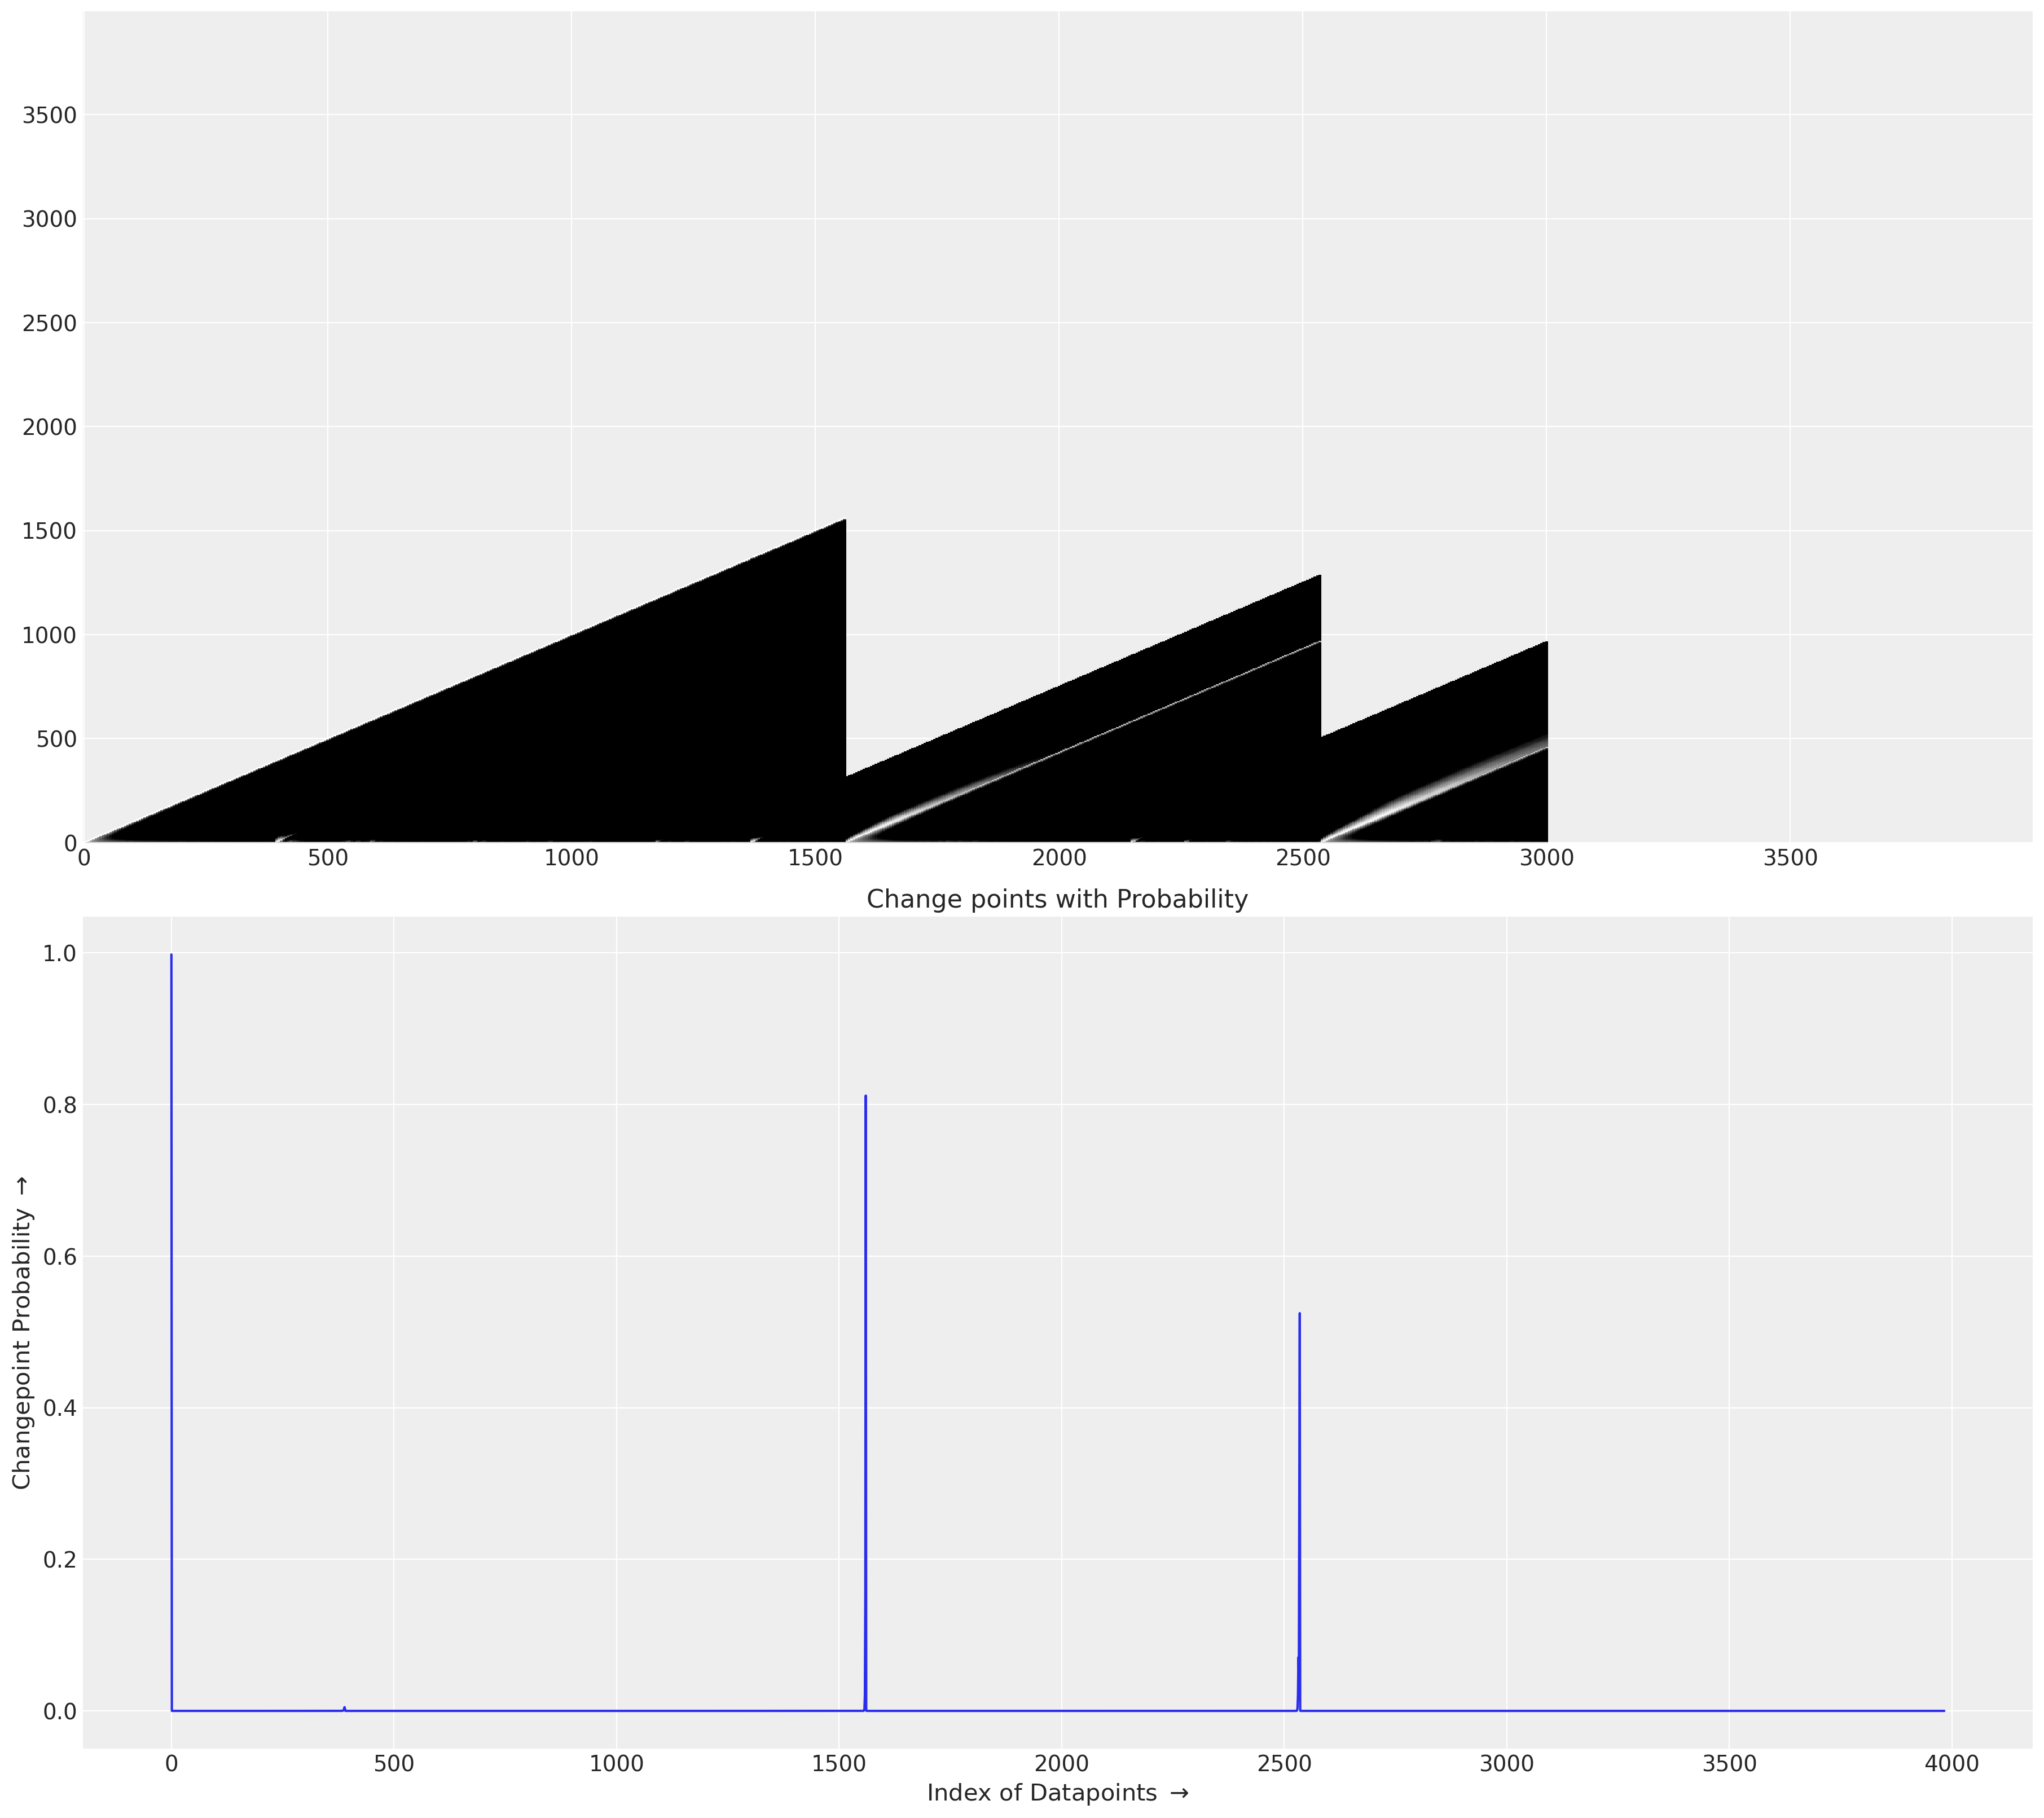

In [35]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig,(ax1,ax2) = plt.subplots(2,figsize=[18, 16])
 

sparsity = 5  # only plot every fifth data for faster display
ax1.pcolor(np.array(range(0, len(bocd.R[:,0]), sparsity)), 
          np.array(range(0, len(bocd.R[:,0]), sparsity)), 
          -np.log(bocd.R[0:-1:sparsity, 0:-1:sparsity]), 
          cmap=cm.Greys, vmin=0, vmax=30)

Nw=15;
ax2.plot(bocd.R[Nw,Nw:-1])
ax2.set_title('Change points with Probability')
ax2.set_xlabel(r"Index of Datapoints $\to$")
ax2.set_ylabel(r"Changepoint Probability $\to$")

Looks like algorithm correctly identifies abrupt changes in trend although there are some false negatives. We will use downtrend changepoints as signals for exit, because as buyers  we are interested in bullish move in underlying.

# References
[1] Ryan P. Adams, David J.C. MacKay, Bayesian Online Changepoint Detection, arXiv 0710.3742 (2007) 

[2]  https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf 

[3] https://techimpactblog.com/bayesian-online-change-point-detection-an-intuitive-understanding-b2d2b9dc165b

 